In [2]:
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pl_bolts
from relative_performer.train import RelativePerformerModel
import matplotlib.pyplot as plt

In [3]:
import os
os.getcwd()

'/Users/hornm/Projects/RelativePerformer/notebooks'

In [4]:
dataset = pl_bolts.datamodules.MNISTDataModule('../data/MNIST')

In [5]:
train_loader = dataset.train_dataloader()
batch = next(train_loader.__iter__())

In [6]:
x, y = batch
x = x.permute(0, 2, 3, 1)
x = x[[0]]

In [7]:
x.shape

torch.Size([1, 28, 28, 1])

In [8]:
model = RelativePerformerModel(dim=128, heads=1, depth=1, in_features=1, max_pos=28, pos_dims=2, pos_scales=8, num_classes=10, embedding_type='linear', no_projection=True)

In [9]:
x_flat, positions = model._flatten_to_sequence(x)

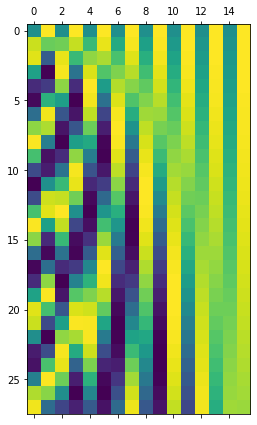

In [10]:
plt.matshow(model._compute_positional_embeddings(positions[:, :28, [1]]).detach().numpy()[0], aspect='auto')

In [11]:
out1 = model(x).detach().numpy()

In [12]:
out2 = model(x_flat, positions).detach().numpy()

In [13]:
out3 = model(x_flat, positions + torch.ones(*positions.shape)).detach().numpy()

In [14]:
np.allclose(out1, out2)

True

In [15]:
np.allclose(out1, out3)

True

In [16]:
out1[0], out3[0]

(array([ 0.33338654,  0.13569857,  0.03346051, -1.5924395 ,  0.43533888,
        -0.11234757,  1.612531  ,  0.4692148 ,  1.1411014 ,  0.39731753],
       dtype=float32),
 array([ 0.33338654,  0.13569857,  0.03346051, -1.5924395 ,  0.43533888,
        -0.11234757,  1.612531  ,  0.4692148 ,  1.1411014 ,  0.39731753],
       dtype=float32))

In [17]:
positions + torch.ones(*positions.shape)

tensor([[[ 1.,  1.],
         [ 1.,  2.],
         [ 1.,  3.],
         ...,
         [28., 26.],
         [28., 27.],
         [28., 28.]]])

In [18]:
projection_matrix = model.performer.net.layers[0][0].fn.to_q._build_positional_projection_matrix()
print(projection_matrix.shape)
# projection_matrix = projection_matrix[:, :32, :32]

torch.Size([1, 16, 2, 2])


In [20]:
from relative_performer.constrained_relative_encoding import ConstrainedLinear, IdentityLinear

to_q, to_k = ConstrainedLinear(1, 2, 16, 2), IdentityLinear(1, 2, 16, 2)

In [21]:
to_q._build_positional_projection_matrix()[0]

tensor([[[ 4.5291e-02, -8.3019e-02],
         [ 8.3019e-02,  4.5291e-02]],

        [[-9.0598e-02, -1.7430e+00],
         [ 1.7430e+00, -9.0598e-02]],

        [[-7.2271e-01,  1.8055e-03],
         [-1.8055e-03, -7.2271e-01]],

        [[ 1.6680e+00,  8.4671e-02],
         [-8.4671e-02,  1.6680e+00]],

        [[ 1.0782e+00, -7.3601e-01],
         [ 7.3601e-01,  1.0782e+00]],

        [[-4.5527e-02, -1.5961e+00],
         [ 1.5961e+00, -4.5527e-02]],

        [[ 2.3779e-01,  7.8486e-01],
         [-7.8486e-01,  2.3779e-01]],

        [[-5.6235e-01, -3.5971e-01],
         [ 3.5971e-01, -5.6235e-01]],

        [[ 9.6512e-01, -4.9414e-01],
         [ 4.9414e-01,  9.6512e-01]],

        [[ 8.0161e-02, -1.4170e+00],
         [ 1.4170e+00,  8.0161e-02]],

        [[ 1.3571e+00, -2.3173e+00],
         [ 2.3173e+00,  1.3571e+00]],

        [[ 4.4214e-01, -2.3168e-01],
         [ 2.3168e-01,  4.4214e-01]],

        [[-2.0335e+00, -6.4503e-01],
         [ 6.4503e-01, -2.0335e+00]],

        [[-2

In [22]:
def compute_dot_prod2(i1, i2, j1, j2):
    positions = torch.Tensor([[i1, i2], [j1, j2], [i1, i2]])[None]
    from einops import rearrange
    encodings = model._compute_positional_embeddings(positions)
    fake_data = torch.zeros(1, 3, 1)
    q = to_q(fake_data, encodings)
    k = to_k(fake_data, encodings)
    print(k)
    # print('q:', q[..., 1:])
    encodings = rearrange(encodings, 'b n (s d) -> b 1 s n d', s=to_q.pos_scales, d=2)
    # Format batch_size, heads, scales, instances, 2
    print(encodings.shape)
    encodings = encodings.matmul(to_q._build_positional_projection_matrix())
    print(encodings.shape)
    encodings = rearrange(encodings, 'b h s n d -> b h n (s d)')
    print(encodings)
    # print('encodings:', encodings)
    # return encodings.matmul(k[..., 1:].transpose(-1, -2))
    print(q.shape, k.shape)
    return encodings.matmul(k[..., 1:].transpose(-1, -2))

# print(compute_dot_prod(0, 0, 1, 1))
print(compute_dot_prod2(0, 0, 1, 1))

tensor([[[[0.3662, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000],
          [0.3662, 0.8415, 0.5403, 0.5684, 0.8227, 0.3575, 0.9339, 0.2192,
           0.9757, 0.1332, 0.9911, 0.0807, 0.9967, 0.0488, 0.9988, 0.0295,
           0.9996, 0.8415, 0.5403, 0.5684, 0.8227, 0.3575, 0.9339, 0.2192,
           0.9757, 0.1332, 0.9911, 0.0807, 0.9967, 0.0488, 0.9988, 0.0295,
           0.9996],
          [0.3662, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
           1.0000]],

         [[0.8741, 0.0000, 1.0000, 0.0